# Use level3 and level5 data

In [2]:
from google.colab import drive
drive.mount('/gdrive')
drive_root = '/gdrive/My\ Drive/'

Mounted at /gdrive


In [3]:
%cd $drive_root
%cd patches

/gdrive/My Drive
/gdrive/My Drive/patches


In [4]:
!ls

tumor_001.tif  tumor_016.tif  tumor_075.tif  tumor_091.tif  tumor_101.tif
tumor_002.tif  tumor_031.tif  tumor_078.tif  tumor_094.tif
tumor_012.tif  tumor_064.tif  tumor_084.tif  tumor_096.tif


In [5]:
import tensorflow as tf

## Preprocess Image

In [6]:
def process_img(img_path1, img_path2):
  img1 = tf.io.read_file(img_path1)
  img1 = tf.image.decode_jpeg(img1, channels=3)
  img1 = tf.cast(img1, tf.float32)
  img1 = tf.keras.applications.inception_v3.preprocess_input(img1)
  img2 = tf.io.read_file(img_path2)
  img2 = tf.image.decode_jpeg(img2, channels=3)
  img2 = tf.cast(img2, tf.float32)
  img2 = tf.keras.applications.inception_v3.preprocess_input(img2)
  return img1, img2

## Show one example of processed image

In [7]:
processed_img1, processed_img2 = process_img("tumor_001.tif/level1/positive/patch_0.jpeg", "tumor_001.tif/level2/positive/patch_0.jpeg")

In [8]:
import matplotlib.pyplot as plt

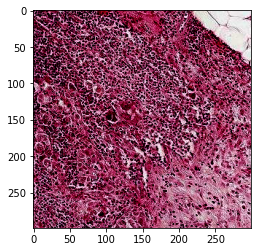

In [9]:
plt.imshow(processed_img1)

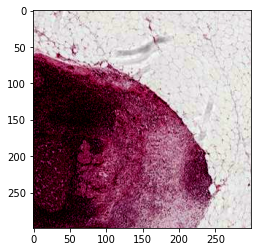

In [10]:
plt.imshow(processed_img2)

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.6 MB/s 


In [25]:
from os import listdir
import numpy as np

In [26]:
slide_paths = listdir('.')
# remove the two negative slides from training
slide_paths.remove('tumor_002.tif')
slide_paths.remove('tumor_012.tif')
neg_slide_paths = ['tumor_002.tif', 'tumor_012.tif']

In [27]:
len(slide_paths)

11

## Make directories to store the augmented/rotated images (only needs to be run once)

In [ ]:
# make directories for augmented images
for slide_path in slide_paths:
  %mkdir $slide_path/level1_aug
  %mkdir $slide_path/level2_aug
  %mkdir $slide_path/level1_aug/positive
  %mkdir $slide_path/level2_aug/positive

## Data Augmentation: rotations by 90, 180, 270 degrees (only needs to be run once)

In [ ]:
import tensorflow_addons as tfa
import math
from PIL import Image
# augment and save
# augmented by rotating counter-clock-wise 90, 180, 270
def data_augmentation(slide_path):
  # level1
  for img_path in listdir(f'{slide_path}/level1/positive'):
    img = tf.io.read_file(f'{slide_path}/level1/positive/{img_path}')
    img = tf.image.decode_jpeg(img, channels=3)
    img1 = tfa.image.rotate(img, 90 * math.pi / 180).numpy()
    img2 = tfa.image.rotate(img, 180 * math.pi / 180).numpy()
    img3 = tfa.image.rotate(img, 270 * math.pi / 180).numpy()
    img1 = Image.fromarray(img1).convert('RGB')
    img2 = Image.fromarray(img2).convert('RGB')
    img3 = Image.fromarray(img3).convert('RGB')
    img_name, img_ext = img_path.split('.')
    img1.save(f'{slide_path}/level1_aug/positive/{img_name}_aug1.{img_ext}')
    img2.save(f'{slide_path}/level1_aug/positive/{img_name}_aug2.{img_ext}')
    img3.save(f'{slide_path}/level1_aug/positive/{img_name}_aug3.{img_ext}')
  # level2
  for img_path in listdir(f'{slide_path}/level2/positive'):
    img = tf.io.read_file(f'{slide_path}/level2/positive/{img_path}')
    img = tf.image.decode_jpeg(img, channels=3)
    img1 = tfa.image.rotate(img, 90 * math.pi / 180).numpy()
    img2 = tfa.image.rotate(img, 180 * math.pi / 180).numpy()
    img3 = tfa.image.rotate(img, 270 * math.pi / 180).numpy()
    img1 = Image.fromarray(img1).convert('RGB')
    img2 = Image.fromarray(img2).convert('RGB')
    img3 = Image.fromarray(img3).convert('RGB')
    img_name, img_ext = img_path.split('.')
    img1.save(f'{slide_path}/level2_aug/positive/{img_name}_aug1.{img_ext}')
    img2.save(f'{slide_path}/level2_aug/positive/{img_name}_aug2.{img_ext}')
    img3.save(f'{slide_path}/level2_aug/positive/{img_name}_aug3.{img_ext}')

In [ ]:
for slide_path in slide_paths:
  data_augmentation(slide_path)

## Show the number of positives and negatives for each slide.

In [14]:
for slide_path in slide_paths:
  n_neg = len(listdir(f'{slide_path}/level1/negative'))
  n_pos = len(listdir(f'{slide_path}/level1/positive')) + len(listdir(f'{slide_path}/level1_aug/positive'))
  print(f"{slide_path}, neg {n_neg}, pos {n_pos}")

tumor_001.tif, neg 501, pos 20
tumor_016.tif, neg 208, pos 156
tumor_031.tif, neg 132, pos 188
tumor_064.tif, neg 212, pos 148
tumor_075.tif, neg 223, pos 104
tumor_084.tif, neg 327, pos 60
tumor_091.tif, neg 196, pos 64
tumor_094.tif, neg 649, pos 60
tumor_096.tif, neg 489, pos 80
tumor_101.tif, neg 462, pos 240
tumor_078.tif, neg 464, pos 996


### Training slides: 'tumor_031.tif', 'tumor_064.tif', 'tumor_075.tif', 'tumor_101.tif', 'tumor_084.tif', 'tumor_078.tif'
### Validation slides: 'tumor_091.tif' , 'tumor_016.tif'
### Test slides: 'tumor_096.tif', 'tumor_094.tif', 'tumor_001.tif'

### Balancing data: randomly select negatives samples so that the number of positive samples equals the number of negative samples

In [28]:
n_all = len(slide_paths)
n_train = 5
n_val = 2
n_test = 3

In [29]:
slide_paths_train = ['tumor_031.tif', 'tumor_064.tif', 'tumor_075.tif', 'tumor_101.tif', 'tumor_084.tif', 'tumor_078.tif']
slide_paths_val = ['tumor_091.tif' , 'tumor_016.tif']
slide_paths_test = ['tumor_096.tif', 'tumor_094.tif', 'tumor_001.tif']

## Level 3

In [30]:
# train
train_data1 = []
train_labels1 = []
for slide_path in slide_paths_train:
  negative1 = listdir(f'{slide_path}/level1/negative')
  negative1 = [f'{slide_path}/level1/negative/'+neg for neg in negative1]
  positive1 = listdir(f'{slide_path}/level1/positive')
  positive1 = [f'{slide_path}/level1/positive/'+pos for pos in positive1]
  # adding augmentation
  positive1_aug = listdir(f'{slide_path}/level1_aug/positive')
  positive1_aug = [f'{slide_path}/level1_aug/positive/'+pos for pos in positive1_aug]
  positive1 = positive1 + positive1_aug
  # randomly pick positives that equal to the size of negatives
  n_pos = len(positive1)
  n_neg = len(negative1)
  neg_data = list(np.random.choice(negative1, size=min(n_pos, n_neg), replace=False))
  pos_data = positive1
  # update
  train_data1 += pos_data
  train_data1 += neg_data
  train_labels1 += [1.0 for i in range(len(pos_data))]
  train_labels1 += [0.0 for i in range(len(neg_data))]

In [31]:
# val
val_data1 = []
val_labels1 = []
for slide_path in slide_paths_val:
  negative1 = listdir(f'{slide_path}/level1/negative')
  negative1 = [f'{slide_path}/level1/negative/'+neg for neg in negative1]
  positive1 = listdir(f'{slide_path}/level1/positive')
  positive1 = [f'{slide_path}/level1/positive/'+pos for pos in positive1]
  # adding augmentation
  positive1_aug = listdir(f'{slide_path}/level1_aug/positive')
  positive1_aug = [f'{slide_path}/level1_aug/positive/'+pos for pos in positive1_aug]
  positive1 = positive1 + positive1_aug
  # randomly pick positives that equal to the size of negatives
  n_pos = len(positive1)
  n_neg = len(negative1)
  neg_data = list(np.random.choice(negative1, size=min(n_pos, n_neg), replace=False))
  pos_data = positive1
  # update
  val_data1 += pos_data
  val_data1 += neg_data
  val_labels1 += [1.0 for i in range(len(pos_data))]
  val_labels1 += [0.0 for i in range(len(neg_data))]

In [32]:
# test
test_data1 = []
test_labels1 = []
for slide_path in slide_paths_test:
  negative1 = listdir(f'{slide_path}/level1/negative')
  negative1 = [f'{slide_path}/level1/negative/'+neg for neg in negative1]
  positive1 = listdir(f'{slide_path}/level1/positive')
  positive1 = [f'{slide_path}/level1/positive/'+pos for pos in positive1]
  # adding augmentation
  positive1_aug = listdir(f'{slide_path}/level1_aug/positive')
  positive1_aug = [f'{slide_path}/level1_aug/positive/'+pos for pos in positive1_aug]
  positive1 = positive1 + positive1_aug
  # randomly pick positives that equal to the size of negatives
  n_pos = len(positive1)
  n_neg = len(negative1)
  neg_data = list(np.random.choice(negative1, size=min(n_pos, n_neg), replace=False))
  pos_data = positive1
  # update
  test_data1 += pos_data
  test_data1 += neg_data
  test_labels1 += [1.0 for i in range(len(pos_data))]
  test_labels1 += [0.0 for i in range(len(neg_data))]

In [33]:
print(len(train_data1))
print(len(val_data1))
print(len(test_data1))

2884
440
320


### Level 5

In [34]:
# train
train_data2 = []
train_labels2 = []
for slide_path in slide_paths_train:
  negative2 = listdir(f'{slide_path}/level2/negative')
  negative2 = [f'{slide_path}/level2/negative/'+neg for neg in negative2]
  positive2 = listdir(f'{slide_path}/level2/positive')
  positive2 = [f'{slide_path}/level2/positive/'+pos for pos in positive2]
  # adding augmentation
  positive2_aug = listdir(f'{slide_path}/level2_aug/positive')
  positive2_aug = [f'{slide_path}/level2_aug/positive/'+pos for pos in positive2_aug]
  positive2 = positive2 + positive2_aug
  # randomly pick positives that equal to the size of negatives
  n_pos = len(positive2)
  n_neg = len(negative2)
  neg_data = list(np.random.choice(negative2, size=min(n_pos, n_neg), replace=False))
  pos_data = positive2
  # update
  train_data2 += pos_data
  train_data2 += neg_data
  train_labels2 += [1.0 for i in range(len(pos_data))]
  train_labels2 += [0.0 for i in range(len(neg_data))]

In [35]:
# val
val_data2 = []
val_labels2 = []
for slide_path in slide_paths_val:
  negative2 = listdir(f'{slide_path}/level2/negative')
  negative2 = [f'{slide_path}/level2/negative/'+neg for neg in negative2]
  positive2 = listdir(f'{slide_path}/level2/positive')
  positive2 = [f'{slide_path}/level2/positive/'+pos for pos in positive2]
  # adding augmentation
  positive2_aug = listdir(f'{slide_path}/level2_aug/positive')
  positive2_aug = [f'{slide_path}/level2_aug/positive/'+pos for pos in positive2_aug]
  positive2 = positive2 + positive2_aug
  # randomly pick positives that equal to the size of negatives
  n_pos = len(positive2)
  n_neg = len(negative2)
  neg_data = list(np.random.choice(negative2, size=min(n_pos, n_neg), replace=False))
  pos_data = positive2
  # update
  val_data2 += pos_data
  val_data2 += neg_data
  val_labels2 += [1.0 for i in range(len(pos_data))]
  val_labels2 += [0.0 for i in range(len(neg_data))]

In [36]:
# test
test_data2 = []
test_labels2 = []
for slide_path in slide_paths_test:
  negative2 = listdir(f'{slide_path}/level2/negative')
  negative2 = [f'{slide_path}/level2/negative/'+neg for neg in negative2]
  positive2 = listdir(f'{slide_path}/level2/positive')
  positive2 = [f'{slide_path}/level2/positive/'+pos for pos in positive2]
  # adding augmentation
  positive2_aug = listdir(f'{slide_path}/level2_aug/positive')
  positive2_aug = [f'{slide_path}/level2_aug/positive/'+pos for pos in positive2_aug]
  positive2 = positive2 + positive2_aug
  # randomly pick positives that equal to the size of negatives
  n_pos = len(positive2)
  n_neg = len(negative2)
  neg_data = list(np.random.choice(negative2, size=min(n_pos, n_neg), replace=False))
  pos_data = positive2
  # update
  test_data2 += pos_data
  test_data2 += neg_data
  test_labels2 += [1.0 for i in range(len(pos_data))]
  test_labels2 += [0.0 for i in range(len(neg_data))]

In [37]:
print(len(train_data2))
print(len(val_data2))
print(len(test_data2))

2884
440
320


### Make tf.Dataset for training, val, test

In [38]:
TRAIN_SIZE = len(train_data1)
rand_ind = np.random.choice([i for i in range(len(train_data1))], size=TRAIN_SIZE, replace=False)
train_data_12 = tf.data.Dataset.from_tensor_slices(([train_data1[i] for i in rand_ind], [train_data2[i] for i in rand_ind]))
train_label = tf.data.Dataset.from_tensor_slices(([train_labels1[i] for i in rand_ind]))
train_data_12 = train_data_12.map(
  process_img, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = tf.data.Dataset.zip((train_data_12, train_label))

train_dataset = train_dataset.shuffle(1000).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [39]:
VAL_SIZE = len(val_data1)
rand_ind = np.random.choice([i for i in range(len(val_data1))], size=VAL_SIZE, replace=False)
val_data_12 = tf.data.Dataset.from_tensor_slices(([val_data1[i] for i in rand_ind], [val_data2[i] for i in rand_ind]))
val_label = tf.data.Dataset.from_tensor_slices(([val_labels1[i] for i in rand_ind]))
val_data_12 = val_data_12.map(
  process_img, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.zip((val_data_12, val_label))

val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [40]:
TEST_SIZE = len(test_data1)
rand_ind = np.random.choice([i for i in range(len(test_data1))], size=TEST_SIZE, replace=False)
test_data_12 = tf.data.Dataset.from_tensor_slices(([test_data1[i] for i in rand_ind], [test_data2[i] for i in rand_ind]))
test_label = tf.data.Dataset.from_tensor_slices(([test_labels1[i] for i in rand_ind]))
test_data_12 = test_data_12.map(
  process_img, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = tf.data.Dataset.zip((test_data_12, test_label))

test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Use Inception v3 and pretrained on imagenet

In [ ]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow import keras

In [ ]:
base_model1 = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
base_model2 = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
for layer in base_model2.layers:
    layer._name = layer.name + str("_2")

In [ ]:
input1 = base_model1.input
output1 = base_model1.output
output1 = GlobalAveragePooling2D()(output1)

input2 = base_model2.input
output2 = base_model2.output
output2 = GlobalAveragePooling2D()(output2)

merged = tf.keras.layers.concatenate([output1, output2])
output = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[input1, input2], outputs=output)

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(model)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
model.fit(train_dataset, validation_data=val_dataset, epochs=2, callbacks=[callback])

Epoch 1/2
91/91 [==============================] - 105s 1s/step - loss: 0.0449 - accuracy: 0.9840 - val_loss: 0.4754 - val_accuracy: 0.8295
Epoch 2/2
91/91 [==============================] - 105s 1s/step - loss: 0.0142 - accuracy: 0.9951 - val_loss: 0.2571 - val_accuracy: 0.9068


### ROC curve on test patches

In [ ]:
prediction = model.predict(test_dataset)

10/10 [==============================] - 16s 2s/step


In [ ]:
from sklearn import metrics

In [ ]:
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(true_labels, prediction, pos_label=1)

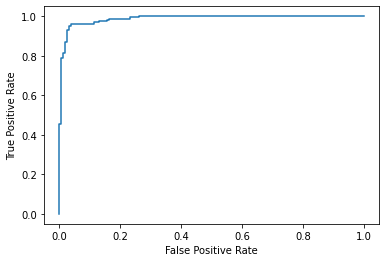

In [ ]:
disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
disp.plot()

### AUC score for test patches is 0.99.
### Test accuracy is 94.69%

In [ ]:
AUC = metrics.auc(fpr, tpr)
print(f'The AUC is {AUC:.2f}')

The AUC is 0.99


In [ ]:
_, acc = model.evaluate(test_dataset)
print(f'Test accuracy is {acc*100:.2f}%')

10/10 [==============================] - 3s 320ms/step - loss: 0.1604 - accuracy: 0.9469
Test accuracy is 94.69%


### Store the optimal threshold.

In [ ]:
optimal_threshold = thresholds[np.argmax(tpr - fpr)]
optimal_threshold

0.2921392

## Slide-level AUC score (as suggested in the paper)

### Here are 5 slides in test set, 3 positive and 2 negative

In [44]:
slide_paths_test

['tumor_096.tif', 'tumor_094.tif', 'tumor_001.tif']

In [45]:
test_paths_set = slide_paths_test + neg_slide_paths
test_paths_set

['tumor_096.tif',
 'tumor_094.tif',
 'tumor_001.tif',
 'tumor_002.tif',
 'tumor_012.tif']

### We tolerate 10 false-positives. So we pick the 10th largest probabilty of all patches in a slide as the slide's probability.

In [ ]:
tf.config.run_functions_eagerly(False)

# Take the max probablity of all patches in a slide as the slide's probability
slide_maxes = []
for slide_path in test_paths_set:
  negative1 = listdir(f'{slide_path}/level1/negative')
  negative1 = [f'{slide_path}/level1/negative/'+neg for neg in negative1]
  positive1 = listdir(f'{slide_path}/level1/positive')
  positive1 = [f'{slide_path}/level1/positive/'+pos for pos in positive1]
  neg_data = negative1
  pos_data = positive1
  test_data1 = pos_data + neg_data
  test_labels1 = [1.0 for i in range(len(pos_data))] + [0.0 for i in range(len(neg_data))]

  negative2 = listdir(f'{slide_path}/level2/negative')
  negative2 = [f'{slide_path}/level2/negative/'+neg for neg in negative2]
  positive2 = listdir(f'{slide_path}/level2/positive')
  positive2 = [f'{slide_path}/level2/positive/'+pos for pos in positive2]
  neg_data = negative2
  pos_data = positive2
  test_data2 = pos_data + neg_data

  test_data_12 = tf.data.Dataset.from_tensor_slices((test_data1, test_data2))
  test_label = tf.data.Dataset.from_tensor_slices((test_labels1))
  test_data_12 = test_data_12.map(
    process_img, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE)
  test_dataset = tf.data.Dataset.zip((test_data_12, test_label))
  test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  pred = list(model.predict(test_dataset))
  pred = [i[0] for i in pred]
  pred.sort(reverse=True)
  print(pred[:10])
  slide_maxes.append(pred[9])

16/16 [==============================] - 9s 592ms/step
[0.99996793, 0.99993014, 0.9996176, 0.9996107, 0.99870825, 0.99857485, 0.99814653, 0.9962316, 0.9924205, 0.9865645]
21/21 [==============================] - 34s 2s/step
[0.9999591, 0.9998988, 0.9998654, 0.9991129, 0.99818915, 0.99813604, 0.9952899, 0.99419856, 0.9941531, 0.9939634]
16/16 [==============================] - 24s 1s/step
[0.99991703, 0.9962321, 0.9744709, 0.9738892, 0.953989, 0.9222862, 0.88385254, 0.794989, 0.6266684, 0.45385855]
7/7 [==============================] - 13s 2s/step
[0.96991247, 0.95445853, 0.9515785, 0.9485564, 0.93044674, 0.88884085, 0.85156125, 0.8283178, 0.80624235, 0.771145]
9/9 [==============================] - 16s 2s/step
[0.24522787, 0.11052202, 0.06691276, 0.05655111, 0.051748745, 0.040211055, 0.028669642, 0.01983361, 0.0181186, 0.015768465]


In [ ]:
slide_maxes

[0.9865645, 0.9939634, 0.45385855, 0.771145, 0.015768465]

### ROC curve for slide-level predictions.

In [ ]:
pred = slide_maxes
true = [1.0] * 3 + [0.0] * 2

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(true, pred, pos_label=1)

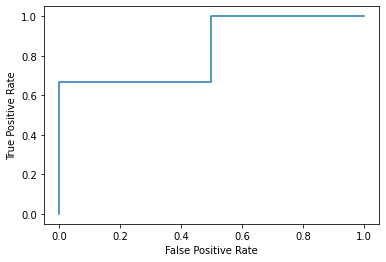

In [ ]:
disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
disp.plot()

### The slide-level AUC score is 0.83

In [ ]:
slide_AUC = metrics.auc(fpr, tpr)
print(f'The slide-level AUC is {slide_AUC:.2f}')

The slide-level AUC is 0.83


## Heat Map of level3: for 3 positive slides in the test set.

In [21]:
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (88.2 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-

In [47]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [48]:
from skimage.color import rgb2gray
import numpy as np
def find_tissue_percent(image, intensity=0.8):
    im_gray = rgb2gray(image)
    percent = np.sum(im_gray <= intensity) / (image.shape[0] * image.shape[1])
    return percent

# ignore the patch if more than 15% is non-tissue
def is_valid(image):
  tissue_percent = find_tissue_percent(image)
  if tissue_percent < 0.15:
    return False
  else:
    return True

In [49]:
test_paths_set

['tumor_096.tif',
 'tumor_094.tif',
 'tumor_001.tif',
 'tumor_002.tif',
 'tumor_012.tif']

### Save model

In [ ]:
model.save("$drive_root/my_model.h5")

### Read model

In [42]:
from keras.models import load_model
drive_root_python = '/gdrive/My Drive/'
model = load_model(f"{drive_root_python}/my_model.h5")

### Heat map for tumor_096: true mask vs heat map

In [52]:
def intersection_over_union(heat_map, tumor_region):
  intersection = np.sum(np.logical_and(heat_map, tumor_region))
  union = np.sum(heat_map) + np.sum(tumor_region) - intersection
  return intersection / union

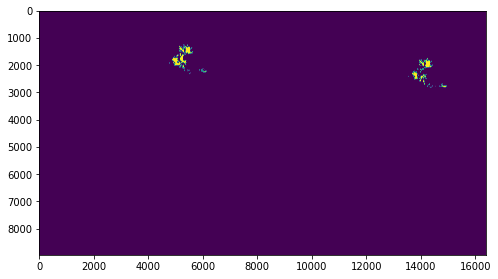

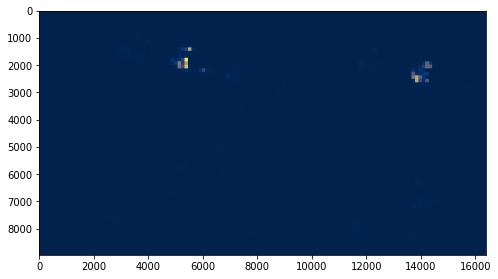

In [37]:
# Heat map
from openslide import open_slide
import numpy as np

level1 = 3
level2 = 5

test_path = test_paths_set[0]

slide = open_slide(f'../slides/{test_path}')
width1 = slide.level_dimensions[level1][0]
height1 = slide.level_dimensions[level1][1]
width2 = slide.level_dimensions[level2][0]
height2 = slide.level_dimensions[level2][1]

whole_region1 = read_slide(slide, x=int(0 * slide.level_downsamples[level1]), y=int(0 * slide.level_downsamples[level1]), level=level1, width=width1, height=height1)
whole_region1 = tf.keras.applications.inception_v3.preprocess_input(whole_region1)
# whole_region2 = read_slide(slide, x=int(0 * slide.level_downsamples[level2]), y=int(0 * slide.level_downsamples[level2]), level=level1, width=width1, height=height2)
# whole_region2 = tf.keras.applications.inception_v3.preprocess_input(whole_region2)

heat_map = np.zeros((height1, width1))

# sliding window with stride 128
cur_width = 0
cur_height = 0

while cur_height+299 < height1:
  cur_width = 0
  while cur_width+299 < width1:
    region1 = whole_region1[cur_height:cur_height+299, cur_width:cur_width+299, :]
    center1_x = cur_width + 299//2
    center1_y = cur_height + 299//2
    center_ori_x = center1_x * slide.level_downsamples[level1]
    ori_x_of_2 = center_ori_x - 299//2*slide.level_downsamples[level2]
    center_ori_y = center1_y * slide.level_downsamples[level1]
    ori_y_of_2 = center_ori_y - 299//2*slide.level_downsamples[level2]
    bound2_x = ori_x_of_2 + 299 * slide.level_downsamples[level2]
    bound2_y = ori_y_of_2 + 299 * slide.level_downsamples[level2]
    if bound2_x > 0 and bound2_y > 0 and bound2_x < slide.level_dimensions[0][0] and bound2_y < slide.level_dimensions[0][1] and is_valid(region1):
      region2 = read_slide(slide, x=int(ori_x_of_2), y=int(ori_y_of_2), level=level2, width=299, height=299)
      region2 = tf.keras.applications.inception_v3.preprocess_input(region2)
      valid_region1 = tf.expand_dims(region1, axis=0)
      valid_region2 = tf.expand_dims(region2, axis=0)
      prob = model.predict((valid_region1, valid_region2), verbose=0)[0][0]
      # update center 128 region
      heat_map[cur_height+85:cur_height+213, cur_width+85:cur_width+213] = np.full((128, 128), prob)
    cur_width += 128
  cur_height += 128

prefix, suffix = test_path.split('.')
tumor_path = prefix + '_mask.' + suffix
tumor = open_slide(f'../slides/{tumor_path}')
tumor_region = read_slide(tumor, x=0, y=0, level=level1, width=tumor.level_dimensions[level1][0], height=tumor.level_dimensions[level1][1])
tumor_region = tumor_region[:,:,0]
plt.figure(figsize=(8,8))
plt.imshow(tumor_region)
plt.figure(figsize=(8,8))
plt.imshow(heat_map, cmap='cividis')

### Intersection over union for tumor_096: 12.7%

In [39]:
intersection_over_union(heat_map >= optimal_threshold, np.array(tumor_region, dtype=bool))

0.12705134652215316

### Heat map for tumor_094: true mask vs heat map

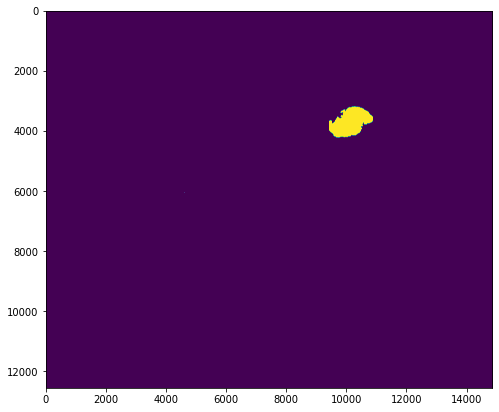

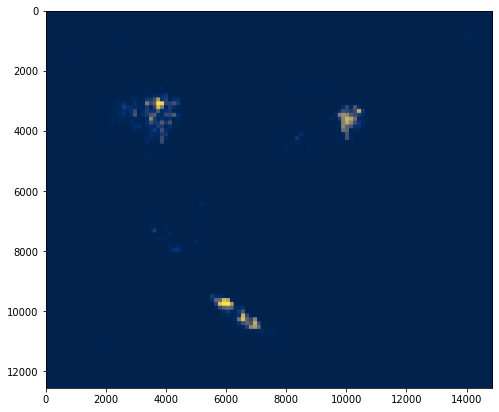

In [149]:
# Heat map
from openslide import open_slide
import numpy as np

level1 = 3
level2 = 5

test_path = test_paths_set[1]

slide = open_slide(f'../slides/{test_path}')
width1 = slide.level_dimensions[level1][0]
height1 = slide.level_dimensions[level1][1]
width2 = slide.level_dimensions[level2][0]
height2 = slide.level_dimensions[level2][1]

whole_region1 = read_slide(slide, x=int(0 * slide.level_downsamples[level1]), y=int(0 * slide.level_downsamples[level1]), level=level1, width=width1, height=height1)
whole_region1 = tf.keras.applications.inception_v3.preprocess_input(whole_region1)
# whole_region2 = read_slide(slide, x=int(0 * slide.level_downsamples[level2]), y=int(0 * slide.level_downsamples[level2]), level=level1, width=width1, height=height2)
# whole_region2 = tf.keras.applications.inception_v3.preprocess_input(whole_region2)

heat_map_1 = np.zeros((height1, width1))

# sliding window with stride 128
cur_width = 0
cur_height = 0

while cur_height+299 < height1:
  cur_width = 0
  while cur_width+299 < width1:
    region1 = whole_region1[cur_height:cur_height+299, cur_width:cur_width+299, :]
    center1_x = cur_width + 299//2
    center1_y = cur_height + 299//2
    center_ori_x = center1_x * slide.level_downsamples[level1]
    ori_x_of_2 = center_ori_x - 299//2*slide.level_downsamples[level2]
    center_ori_y = center1_y * slide.level_downsamples[level1]
    ori_y_of_2 = center_ori_y - 299//2*slide.level_downsamples[level2]
    bound2_x = ori_x_of_2 + 299 * slide.level_downsamples[level2]
    bound2_y = ori_y_of_2 + 299 * slide.level_downsamples[level2]
    if bound2_x > 0 and bound2_y > 0 and bound2_x < slide.level_dimensions[0][0] and bound2_y < slide.level_dimensions[0][1] and is_valid(region1):
      region2 = read_slide(slide, x=int(ori_x_of_2), y=int(ori_y_of_2), level=level2, width=299, height=299)
      region2 = tf.keras.applications.inception_v3.preprocess_input(region2)
      valid_region1 = tf.expand_dims(region1, axis=0)
      valid_region2 = tf.expand_dims(region2, axis=0)
      prob = model.predict((valid_region1, valid_region2), verbose=0)[0][0]
      # update center 128 region
      heat_map_1[cur_height+85:cur_height+213, cur_width+85:cur_width+213] = np.full((128, 128), prob)
    cur_width += 128
  cur_height += 128

prefix, suffix = test_path.split('.')
tumor_path = prefix + '_mask.' + suffix
tumor = open_slide(f'../slides/{tumor_path}')
tumor_region_1 = read_slide(tumor, x=0, y=0, level=level1, width=tumor.level_dimensions[level1][0], height=tumor.level_dimensions[level1][1])
tumor_region_1 = tumor_region_1[:,:,0]
plt.figure(figsize=(8,8))
plt.imshow(tumor_region_1)
plt.figure(figsize=(8,8))
plt.imshow(heat_map_1, cmap='cividis')

### Intersection over union for tumor_094: 15.86%

In [150]:
intersection_over_union(heat_map_1 >= optimal_threshold, np.array(tumor_region_1, dtype=bool))

0.15862361616902038

### Heat map for tumor_001: true mask vs heat map

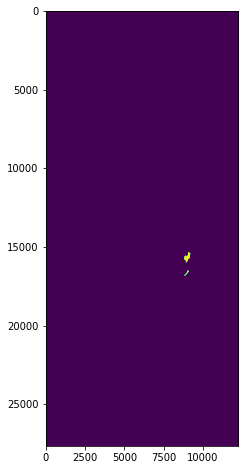

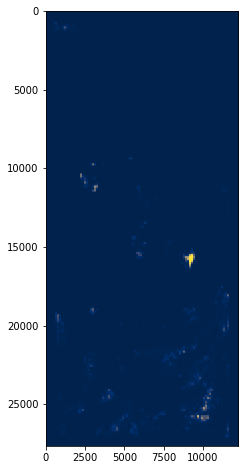

In [50]:
# Heat map
from openslide import open_slide
import numpy as np

level1 = 3
level2 = 5

test_path = test_paths_set[2]

slide = open_slide(f'../slides/{test_path}')
width1 = slide.level_dimensions[level1][0]
height1 = slide.level_dimensions[level1][1]
width2 = slide.level_dimensions[level2][0]
height2 = slide.level_dimensions[level2][1]

whole_region1 = read_slide(slide, x=int(0 * slide.level_downsamples[level1]), y=int(0 * slide.level_downsamples[level1]), level=level1, width=width1, height=height1)
whole_region1 = tf.keras.applications.inception_v3.preprocess_input(whole_region1)
# whole_region2 = read_slide(slide, x=int(0 * slide.level_downsamples[level2]), y=int(0 * slide.level_downsamples[level2]), level=level1, width=width1, height=height2)
# whole_region2 = tf.keras.applications.inception_v3.preprocess_input(whole_region2)

heat_map_2 = np.zeros((height1, width1))

# sliding window with stride 128
cur_width = 0
cur_height = 0

while cur_height+299 < height1:
  cur_width = 0
  while cur_width+299 < width1:
    region1 = whole_region1[cur_height:cur_height+299, cur_width:cur_width+299, :]
    center1_x = cur_width + 299//2
    center1_y = cur_height + 299//2
    center_ori_x = center1_x * slide.level_downsamples[level1]
    ori_x_of_2 = center_ori_x - 299//2*slide.level_downsamples[level2]
    center_ori_y = center1_y * slide.level_downsamples[level1]
    ori_y_of_2 = center_ori_y - 299//2*slide.level_downsamples[level2]
    bound2_x = ori_x_of_2 + 299 * slide.level_downsamples[level2]
    bound2_y = ori_y_of_2 + 299 * slide.level_downsamples[level2]
    if bound2_x > 0 and bound2_y > 0 and bound2_x < slide.level_dimensions[0][0] and bound2_y < slide.level_dimensions[0][1] and is_valid(region1):
      region2 = read_slide(slide, x=int(ori_x_of_2), y=int(ori_y_of_2), level=level2, width=299, height=299)
      region2 = tf.keras.applications.inception_v3.preprocess_input(region2)
      valid_region1 = tf.expand_dims(region1, axis=0)
      valid_region2 = tf.expand_dims(region2, axis=0)
      prob = model.predict((valid_region1, valid_region2), verbose=0)[0][0]
      # update center 128 region
      heat_map_2[cur_height+85:cur_height+213, cur_width+85:cur_width+213] = np.full((128, 128), prob)
    cur_width += 128
  cur_height += 128

prefix, suffix = test_path.split('.')
tumor_path = prefix + '_mask.' + suffix
tumor = open_slide(f'../slides/{tumor_path}')
tumor_region_2 = read_slide(tumor, x=0, y=0, level=level1, width=tumor.level_dimensions[level1][0], height=tumor.level_dimensions[level1][1])
tumor_region_2 = tumor_region_2[:,:,0]
plt.figure(figsize=(8,8))
plt.imshow(tumor_region_2)
plt.figure(figsize=(8,8))
plt.imshow(heat_map_2, cmap='cividis')

### Intersection over union for tumor_001: 12.53%

In [53]:
intersection_over_union(heat_map_2 >= optimal_threshold, np.array(tumor_region_2, dtype=bool))

0.12533358829931132